In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Feature selection

## Correlation based

In [27]:
data_engineered = pd.read_csv('data/preprocessed_data_engineered.csv')
data_engineered.set_index('PUF_ID', inplace=True)

In [28]:
# get all columns with more values than 0 and 1
num_feats = list(filter(lambda x: data_engineered[x].nunique() > 2, data_engineered.columns.values))

cat_feats = list(filter(lambda x: data_engineered[x].nunique() == 2, data_engineered.columns.values))

<AxesSubplot:>

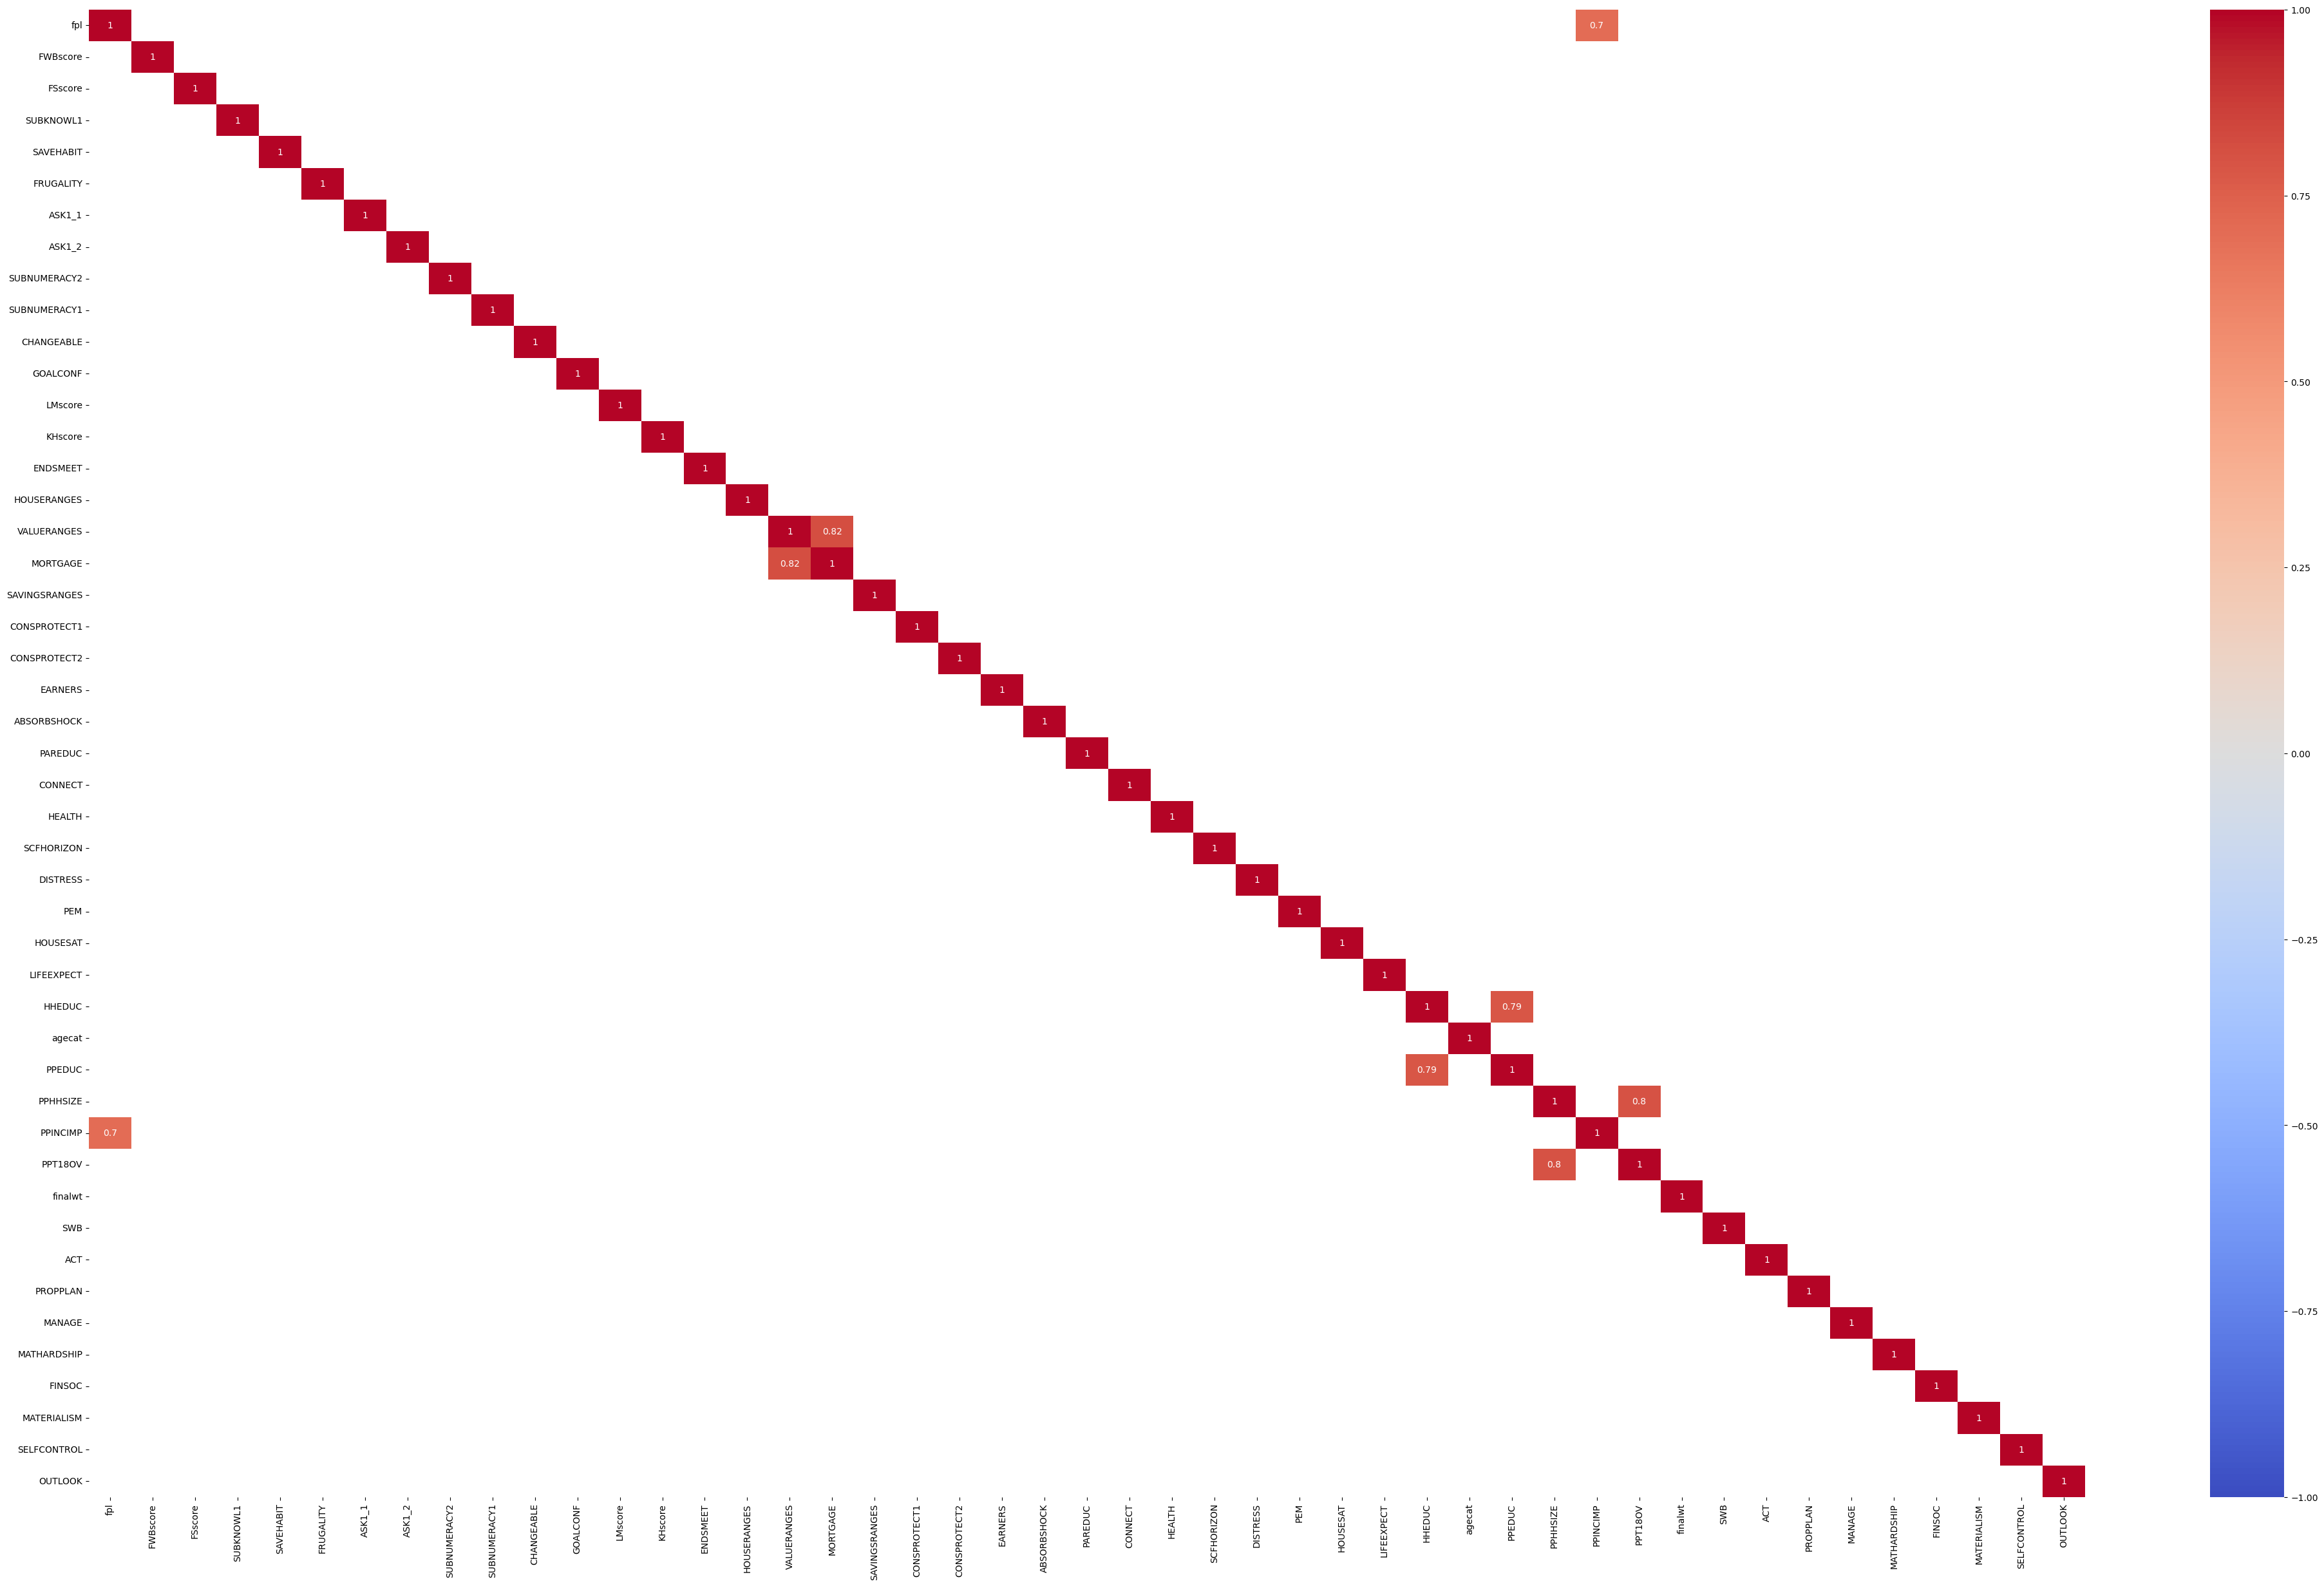

In [29]:
# sns heatmap with annot and only on one side of the diagonal and only on correlations above 0.7
plt.figure(figsize = (50, 30))
sns.heatmap(data_engineered[num_feats].corr(method = 'spearman')[data_engineered[num_feats].corr(method = 'spearman') > 0.7].dropna(how = 'all').dropna(how = 'all', axis = 1), annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1)

In [30]:
# get pairs of features with correelation above 0.7
corr = data_engineered[num_feats].corr(method = 'spearman')
corr[corr > 0.7].notna().sum()[corr[corr > 0.7].notna().sum() > 1] # columns that are highly correlated with others

fpl            2
VALUERANGES    2
MORTGAGE       2
HHEDUC         2
PPEDUC         2
PPHHSIZE       2
PPINCIMP       2
PPT18OV        2
dtype: int64

In [31]:
data_engineered.corr(method = 'spearman')['MORTGAGE'].mean()

0.035577550171268124

In [32]:
data_engineered.corr(method = 'spearman')['VALUERANGES'].mean()

0.04101976125632419

In [33]:
data_feat_selection = data_engineered.copy()

data_feat_selection.drop(['VALUERANGES', 'HHEDUC', 'PPT18OV'], axis = 1, inplace = True)

In [34]:
data_feat_selection.shape

(6038, 164)

## Recursive Feature Elimination

We have 162 features. I want to keep only 80.

In [227]:
from sklearn.feature_selection import RFECV, RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [166]:
X = data_feat_selection.drop('fpl', axis = 1)
Y = data_feat_selection['fpl']

In [169]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = Y)

In [170]:
X_train_sample_weights = X_train['finalwt']
X_train.drop('finalwt', axis = 1, inplace = True)
X_val_sample_weights = X_val['finalwt']
X_val.drop('finalwt', axis = 1, inplace = True)

In [171]:
class_weights = compute_class_weight('balanced', classes=[1, 2, 3], y=y_train)
weights = {}
for i, value in enumerate(class_weights):
    weights[i + 1] = value

In [172]:
weights

{1: 3.3823529411764706, 2: 2.523510971786834, 3: 0.4332615715823466}

In [173]:
X_train_weights = y_train.map({k: v for k, v in weights.items()})
X_val_weights = y_val.map({k: v for k, v in weights.items()})

In [174]:
def rfe_selection(X_train, y_train, X_val, y_val, min_feats):
  """
    Function that selects the K most important features according to RFE.
    The k is dinamically choosen by calculating the scores of the model with values of K ranging from 1 to the number of features.
  """
  nr_features_list = list(range(min_feats, len(X_train.columns) +1))
  highest_score=0

  score_list = []

  # to select the best nr of features to keep
  for n in nr_features_list:
    # create model for the RFE to use
    model = DecisionTreeClassifier(random_state = 20)

    # create RFE object to select the best n features
    rfe = RFE(estimator = model, n_features_to_select = n)
    X_train_rfe = rfe.fit_transform(X_train, y_train, sample_weight = X_train_sample_weights)
    X_val_rfe = rfe.transform(X_val)

    # fit the model with the selected features
    model.fit(X_train_rfe, y_train, sample_weight = X_train_sample_weights)
    
    # model score
    y_pred = model.predict(X_val_rfe)
    score = f1_score(y_val, y_pred, average = 'weighted', sample_weight = X_val_weights)
    score_list.append(score)
    
    # select the number of features that show the highest score
    if(score>highest_score):
      selected_features = X_train.columns[rfe.support_].values
      highest_score = score

  return selected_features

In [175]:
sel_features = rfe_selection(X_train, y_train, X_val, y_val, min_feats = 80)

In [176]:
len(sel_features)

158

In [212]:
X = data_feat_selection[np.append(sel_features, 'finalwt')]
Y = data_feat_selection['fpl']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = Y)

X_train_sample_weights = X_train['finalwt']
X_train.drop('finalwt', axis = 1, inplace = True)
X_val.drop('finalwt', axis = 1, inplace = True)

In [228]:
model = GradientBoostingClassifier(random_state = 20)
model.fit(X_train, y_train, sample_weight = X_train_sample_weights)

y_pred = model.predict(X_val)

In [229]:
class_weights = compute_class_weight('balanced', classes=[1, 2, 3], y=y_train)
weights = {}
for i, value in enumerate(class_weights):
    weights[i + 1] = value

X_train_weights = y_train.map({k: v for k, v in weights.items()})
X_val_weights = y_val.map({k: v for k, v in weights.items()})

In [230]:
y_pred

array([3, 3, 2, ..., 3, 3, 3])

In [231]:
f1_score(y_val, y_pred, average='weighted', sample_weight = X_val_weights)

0.8951053579711574

In [232]:
sum(y_pred != y_val)

50

In [43]:
data_feat_selection.to_csv('data/preprocessed_data_feat_selection.csv')